Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [114]:
HYPERTRAINING = False
CV = 5
SCORING = ''
CLASS_WEIGHTS = 'balanced'
EXPERIEMENT_NAME = "offense_potential_predictor_regression"
RUN_NAME = None
TARGET_OVERALL = 80

PLAYER_ATTRIBUTES = [ 'central','winger','offense','Finishing',  'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping',  'LongShots', 'Positioning', 'Vision' ]
# PLAYER_ATTRIBUTES = [ 'Age' ,'Dribbling',  'FKAccuracy',  'BallControl','ShotPower','Positioning', 'Penalties' ]
PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackleshooting_technique', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']
PLAYER_ATTRIBUTES = ['Reactions', 'age_based_Stamina', 'Positioning', 'ShortPassing',  'Dribbling', 'BallControl',    'Aggression',   'Vision',  'SprintSpeed','shooting']
PLAYER_ATTRIBUTES = ['Crossing', 'Finishing','shooting_technique','mental'
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl',  'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression',  'Positioning', 'Vision',
       'Penalties',  
        'youth_player', 'shooting', 
       'mental', 'physique', 'Speed', 'ball_handling', 'age_based_Reactions',
       'age_based_physique', 'age_based_shooting_technique',
       'age_based_Stamina', 'age_based_Positioning', 'age_based_Vision',
       'age_based_Finishing', 'age_based_BallControl']

PLAYER_ATTRIBUTES = [ 'age_based_shooting','shooting', 'ShortPassing','Dribbling',    'BallControl',
                     'SprintSpeed', 'Agility','Composure', 'Reactions', 
                       'age_based_Stamina', 'Aggression', 'Interceptions', 'Positioning', 'age_based_Vision']

PLAYER_ATTRIBUTES = [ 'shooting', 'Potential','age_based_shooting',
       'mental', 'physique', 'Speed', 'ball_handling', 'age_based_Reactions',
       'age_based_physique', 'age_based_shooting_technique',
       'age_based_Stamina', 'age_based_Positioning', 'age_based_Vision',
       'age_based_Finishing', 'age_based_BallControl']


In [115]:
import os
import pandas as pd
import numpy as np
import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")
find_and_append_module_path()
os.getcwd()

from src.sport_analytics.model.prepare import add_features_raw_datadf_raw
from src.sport_analytics.model.eval import plot_feature_importance,plot_shap_summary,plot_auc_curves

New current directory: c:\Users\Robert\Documents\Projekte\dev\statsfaction


### Get Data

In [116]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT *,Potential as max_potential FROM fifa WHERE Potential>={TARGET_OVERALL})
GROUP BY ID
order by potential DESC;
"""



In [117]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import sqlite3
DATABASE_PATH = "data/sport_analytics/database/football.db"
# Step 1: Establish a database connection
conn = sqlite3.connect(DATABASE_PATH)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw_datadf_raw(df_raw)

df_raw.head()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,ball_handling,age_based_Reactions,age_based_physique,age_based_shooting_technique,age_based_Stamina,age_based_Positioning,age_based_Vision,age_based_Finishing,age_based_BallControl,age_based_shooting
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,94.2,15.742424,-4.863636,26.616667,1.750000,30.401515,22.386364,35.196970,25.765152,31.424242
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,92.2,13.169643,8.799107,26.707143,10.535714,26.562500,9.500000,30.133929,23.366071,28.907738
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,...,80.2,12.425926,9.250000,16.803704,9.037037,15.351852,15.092593,19.259259,14.574074,15.234568
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,83.0,11.125000,-0.210227,16.313636,6.477273,22.250000,21.750000,22.977273,18.102273,19.503788
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,83.2,17.019608,0.872549,23.164706,16.372549,28.725490,14.196078,28.137255,15.431373,28.457516


# 

In [118]:
df_raw.Overall
df_raw.Potential

ID      Name               FIFA
158023  L. Messi           2011    95.0
20801   Cristiano Ronaldo  2011    94.0
244778  Trincão            2021    91.0
183277  E. Hazard          2011    91.0
243812  Rodrygo            2021    90.0
                                   ... 
20486   Carlinhos Bala     2011    81.0
193268  A. Gerbo           2011    80.0
189437  C. Pasquato        2011    80.0
135499  Dagoberto          2011    80.0
1551    L. Giuly           2011    80.0
Name: Potential, Length: 6400, dtype: float64

In [119]:
df_raw.PrimeOverall

ID      Name               FIFA
158023  L. Messi           2011    94.0
20801   Cristiano Ronaldo  2011    94.0
244778  Trincão            2021    78.0
183277  E. Hazard          2011    91.0
243812  Rodrygo            2021    81.0
                                   ... 
20486   Carlinhos Bala     2011    69.0
193268  A. Gerbo           2011    65.0
189437  C. Pasquato        2011    74.0
135499  Dagoberto          2011    77.0
1551    L. Giuly           2011    76.0
Name: PrimeOverall, Length: 6400, dtype: float64

In [120]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'test', 2020: 'test', 2021: 'test', 2022: 'test', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Overall<TARGET_OVERALL)&(df.Age<26)&(df.Potential>=TARGET_OVERALL)]

target
77.0    77
78.0    63
75.0    61
76.0    52
79.0    47
73.0    47
74.0    46
81.0    39
71.0    37
70.0    35
80.0    35
72.0    33
83.0    31
68.0    30
84.0    30
82.0    28
67.0    24
69.0    24
64.0    15
66.0    14
85.0    12
65.0    10
87.0     9
86.0     7
88.0     6
90.0     6
89.0     6
62.0     4
91.0     4
63.0     4
92.0     3
61.0     2
94.0     2
57.0     1
58.0     1
Name: count, dtype: int64


array([[<Axes: title={'center': 'potential_age'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Overall'}>,
        <Axes: title={'center': 'Potential'}>,
        <Axes: title={'center': 'Special'}>,
        <Axes: title={'center': 'Unnamed: 0'}>,
        <Axes: title={'center': 'Crossing'}>,
        <Axes: title={'center': 'Finishing'}>],
       [<Axes: title={'center': 'HeadingAccuracy'}>,
        <Axes: title={'center': 'ShortPassing'}>,
        <Axes: title={'center': 'Volleys'}>,
        <Axes: title={'center': 'Dribbling'}>,
        <Axes: title={'center': 'Curve'}>,
        <Axes: title={'center': 'FKAccuracy'}>,
        <Axes: title={'center': 'LongPassing'}>,
        <Axes: title={'center': 'BallControl'}>],
       [<Axes: title={'center': 'Acceleration'}>,
        <Axes: title={'center': 'SprintSpeed'}>,
        <Axes: title={'center': 'Agility'}>,
        <Axes: title={'center': 'Reactions'}>,
        <Axes: title={'center': 'Balance'}>,
        

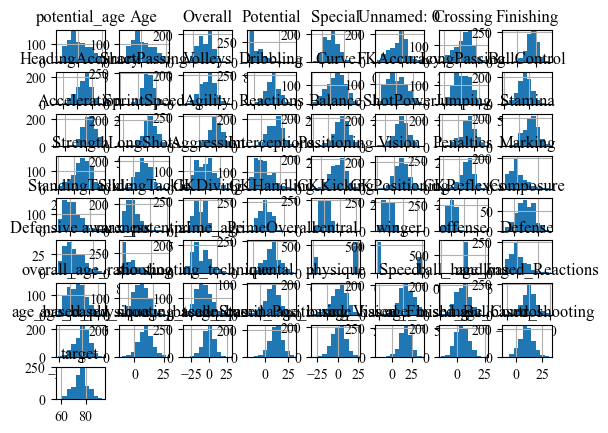

In [121]:

df = df[df.prime_age>df.potential_age]
df['target'] = df.PrimeOverall
df = df[df.potential_age<26]
df = df[df.offense>0.5]
print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()
df_processed.hist()

In [122]:
df_processed.best_position.value_counts()

best_position
ST    487
LW    141
RW    124
CF     75
RF     10
LF      8
Name: count, dtype: int64

In [123]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,24.0,95.0,95.0,90.0,94.0,94.0,drop,RW
20801,Cristiano Ronaldo,2011,25.0,25.0,31.0,94.0,94.0,89.0,94.0,94.0,drop,RW
183277,E. Hazard,2011,19.0,19.0,27.0,91.0,91.0,81.0,91.0,91.0,drop,RW
243812,Rodrygo,2021,19.0,19.0,21.0,90.0,90.0,79.0,81.0,81.0,test,RW
208790,Z. Bakkali,2014,17.0,17.0,20.0,90.0,90.0,73.0,74.0,74.0,train,RW


In [124]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

## Deskriptive Analyse

In [125]:
df.select_dtypes(exclude='object').corr()['target'].round(2).sort_values().head(100)

youth_player        -0.35
overall_age_ratio   -0.16
central             -0.07
GKPositioning       -0.03
GKReflexes          -0.02
                     ... 
Special              0.64
Overall              0.72
PrimeOverall         1.00
target               1.00
offense               NaN
Name: target, Length: 66, dtype: float64

In [126]:
df[df.Age<20].describe().round(0).compare(df[df.Age>=20].describe().round(0))

potential_age           Age        Overall        Potential         \
               self  other   self  other    self  other      self  other   
count         384.0  461.0  384.0  461.0   384.0  461.0     384.0  461.0   
mean           18.0   22.0   18.0   22.0    66.0   73.0       NaN    NaN   
std             1.0    2.0    1.0    2.0     4.0    5.0       NaN    NaN   
min            16.0   20.0   16.0   20.0    54.0   58.0       NaN    NaN   
25%            18.0   21.0   18.0   21.0    63.0   70.0      81.0   80.0   
50%            18.0   22.0   18.0   22.0    66.0   73.0       NaN    NaN   
75%            19.0   23.0   19.0   23.0    69.0   76.0       NaN    NaN   
max            19.0   25.0   19.0   25.0    81.0   90.0      91.0   95.0   

      Special          ... age_based_Vision        age_based_Finishing         \
         self   other  ...             self  other                self  other   
count   384.0   461.0  ...            384.0  461.0               384.0  461.0   
mean   1611.0  1795.0  ...              1.0    2.0                14.0   18.0   
std     120.0   133.0  ...              8.0    9.0                 NaN    NaN   
min    1303.0  1462.0  ...            -30.0  -27.0               -19.0  -10.0   
25%    1530.0  1711.0  ...             -5.0   -3.0                10.0   14.0   
50%    1594.0  1791.0  ...              1.0    3.0                14.0   19.0   
75%    1694.0  1877.0  ...              6.0    8.0                19.0   23.0   
max    1979.0  2316.0  ...             24.0   23.0                32.0   37.0   

      age_based_BallControl        age_based_shooting        target         
                       self  other               self  other   self  other  
count                 384.0  461.0              384.0  461.0  384.0  461.0  
mean                    4.0    6.0                8.0   12.0   74.0   78.0  
std                     NaN    NaN                NaN    NaN    6.0    5.0  
min                   -12.0  -15.0              -10.0   -9.0   57.0   65.0  
25%                    -0.0    1.0                4.0    8.0   69.0   75.0  
50%                     3.0    5.0                8.0   12.0   74.0   77.0  
75%                     8.0    9.0               12.0   16.0   78.0   81.0  
max                    21.0   26.0               28.0   31.0   91.0   94.0  

[8 rows x 130 columns]

###  Feature Engineering

#### Transform Value

In [127]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

<Axes: >

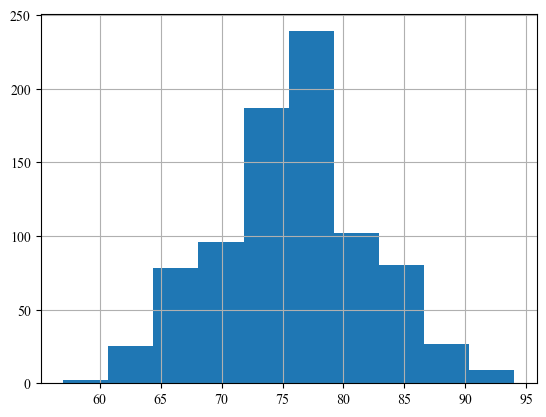

In [128]:
df['target'].hist()

In [129]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [130]:


from sklearn.model_selection import train_test_split
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [131]:
y_train.describe()

count    383.000000
mean      76.671018
std        5.397922
min       57.000000
25%       73.000000
50%       77.000000
75%       80.000000
max       92.000000
Name: target, dtype: float64

In [132]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')

import pandas as pd

from sklearn.preprocessing import StandardScaler
# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training 
# and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [133]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),  # Adjust the range
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),  # Adjust the range
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
            'criterion': 'entropy',  # or 'entropy' depending on your problem
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestClassifier(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_auc = cv_scores.mean()

        return mean_auc

    # Create an Optuna study for maximizing AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_auc = study.best_value

    print("Best hyperparameters:", PARAMS_RF)
    print(f"Best {SCORING}:", best_auc)
else:
    PARAMS_RF = {}

In [134]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 12),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),  # Adjust the range
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),  # Adjust the range
            'max_features': trial.suggest_float('max_features', 0.1, 1.0),
            'criterion': 'gini',  # or 'entropy' depending on your problem
            'random_state': 42
        }

        # Create the Decision Tree classifier with the given hyperparameters
        clf = DecisionTreeClassifier(**params)

        # Implement cross-validation to calculate mean AUC
        cv_scores = cross_val_score(clf, X_train_scaled_df, y_train, cv=CV, scoring='recall_macro')
        mean_auc = cv_scores.mean()

        return mean_auc

    # Create an Optuna study for maximizing AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # You can increase n_trials for more optimization

    PARAM_DT = study.best_params
    best_auc = study.best_value

    print("Best hyperparameters:", PARAM_DT)
    print(f"Best {SCORING}:", best_auc)
else:
    PARAM_DT = {}

In [135]:
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'objective': 'binary:logistic',
            'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_uniform('min_child_weight', 1.0, 20.0),
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
            'reg_alpha': trial.suggest_uniform('reg_alpha', 0.1, 1.0),
            'reg_lambda': trial.suggest_uniform('reg_lambda', 0.01, 0.1),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        }
        # Implement early stopping with cross-validation
        cv_scores = []

        clf = XGBClassifier(**params, random_state=42, n_jobs=-1)
        # Implement cross-validation to calculate mean AUC
        cv_scores = cross_val_score(clf, X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_auc = cv_scores.mean()

        return mean_auc
    # Create an Optuna study for maximizing AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # You can increase n_trials for more optimization

    PARAM_XGB = study.best_params
    best_auc = study.best_value

    print("Best hyperparameters:", PARAM_XGB)
    print(f"Best {SCORING}:", best_auc)
else:
    PARAM_XGB = {}


# TODOS
- SHAP Values for Regression Models -> DONE
- SCV and Logistic Regression
- Hyperparameter Tuning
- classification model einbauen

Linear Regression training----->


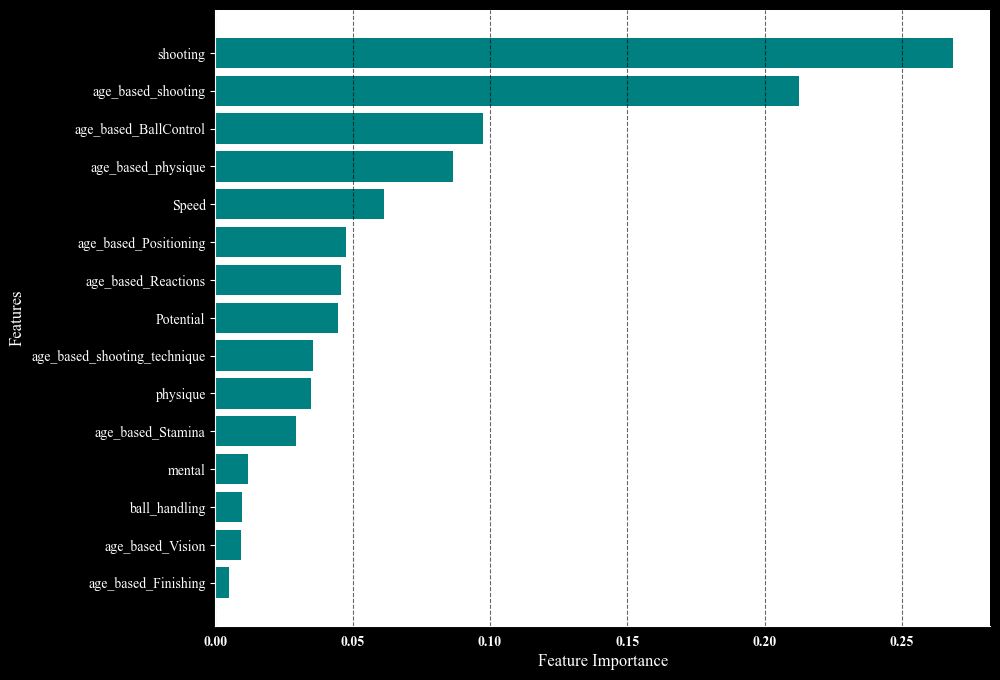

Using 234 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 30/30 [01:01<00:00,  2.07s/it]


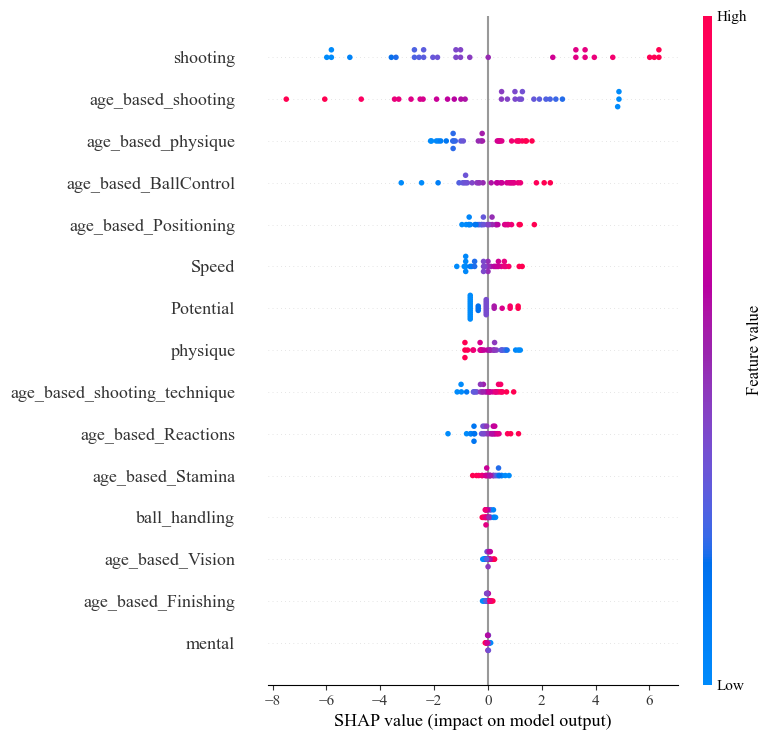

              precision    recall  f1-score   support

       False       0.93      0.97      0.95       211
        True       0.53      0.35      0.42        23

    accuracy                           0.91       234
   macro avg       0.73      0.66      0.68       234
weighted avg       0.89      0.91      0.90       234

Decision Tree Regressor training----->


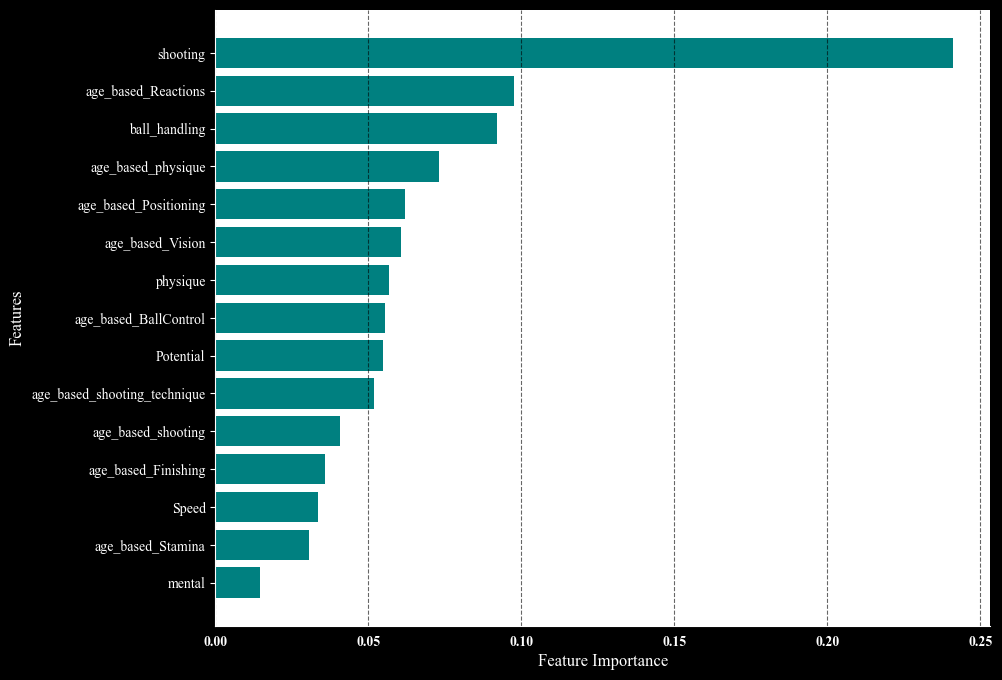

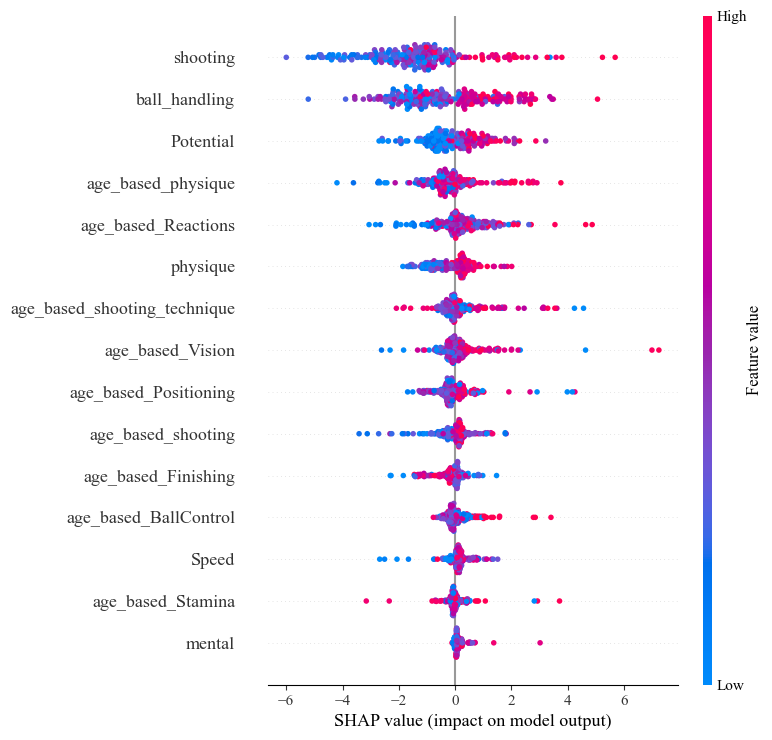

              precision    recall  f1-score   support

       False       0.92      0.86      0.89       211
        True       0.19      0.30      0.24        23

    accuracy                           0.81       234
   macro avg       0.56      0.58      0.56       234
weighted avg       0.85      0.81      0.83       234

Random Forest Regressor training----->


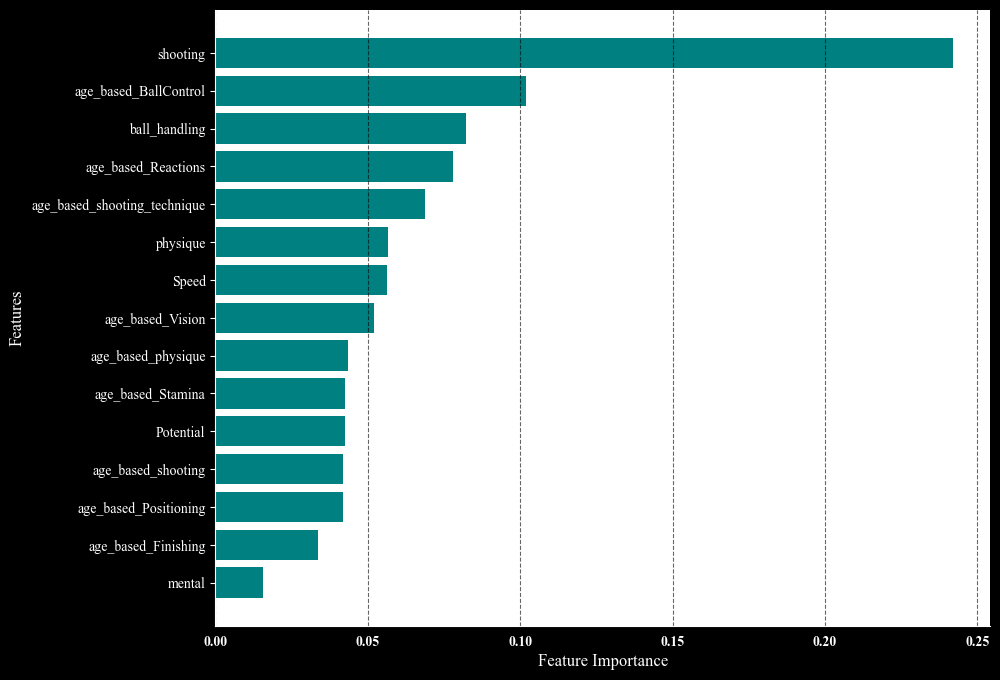

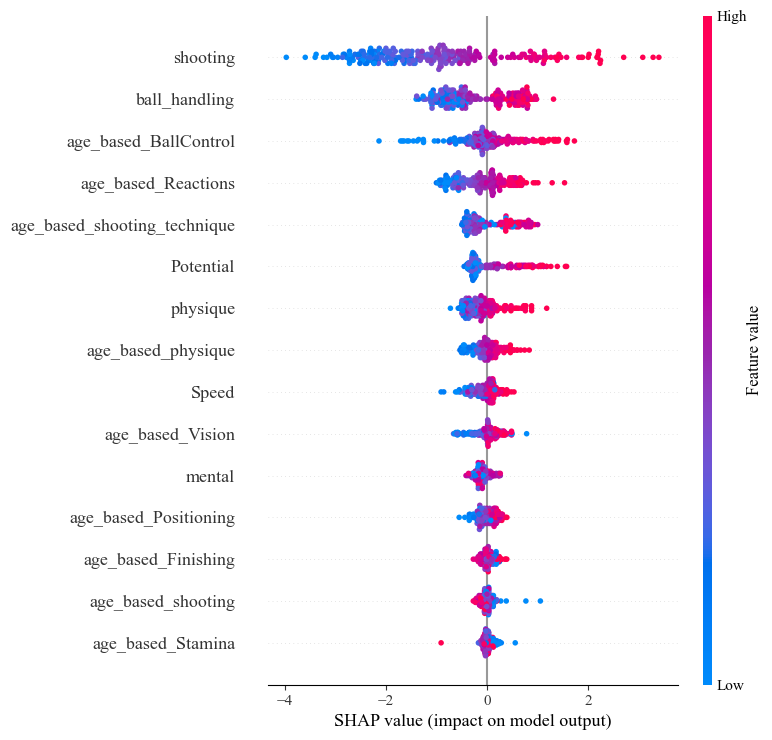

              precision    recall  f1-score   support

       False       0.93      0.95      0.94       211
        True       0.44      0.35      0.39        23

    accuracy                           0.89       234
   macro avg       0.69      0.65      0.67       234
weighted avg       0.88      0.89      0.89       234

XGBoost Regressor training----->


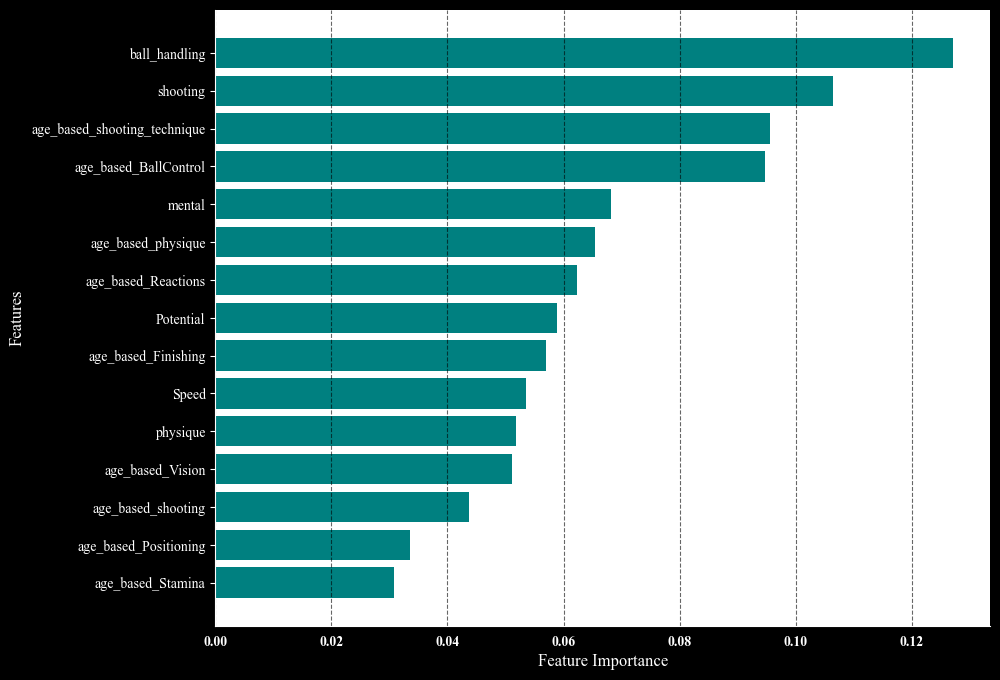

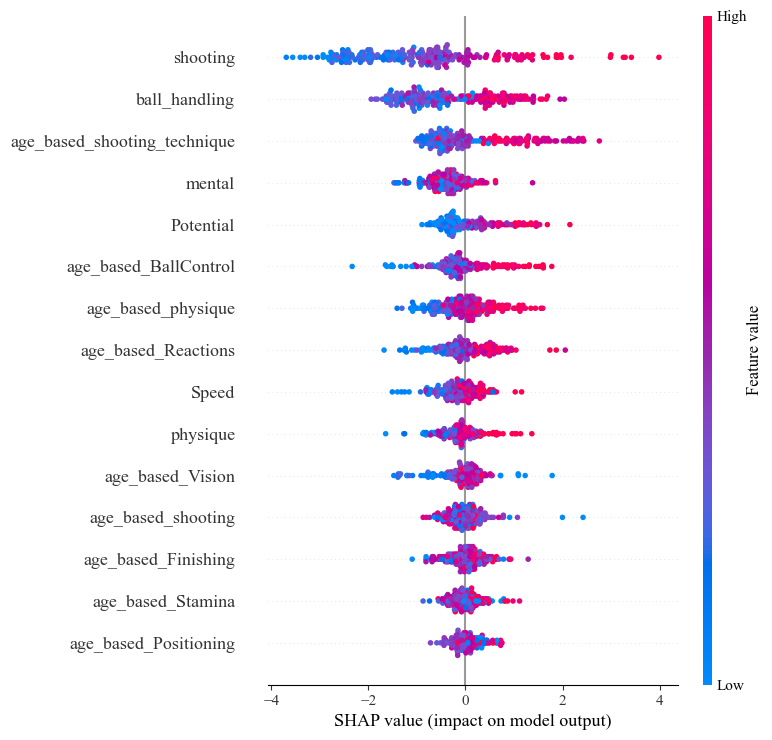

              precision    recall  f1-score   support

       False       0.92      0.93      0.93       211
        True       0.33      0.30      0.32        23

    accuracy                           0.87       234
   macro avg       0.63      0.62      0.62       234
weighted avg       0.87      0.87      0.87       234

LightGBM Regressor training----->
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1458
[LightGBM] [Info] Number of data points in the train set: 383, number of used features: 15
[LightGBM] [Info] Start training from score 76.671018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

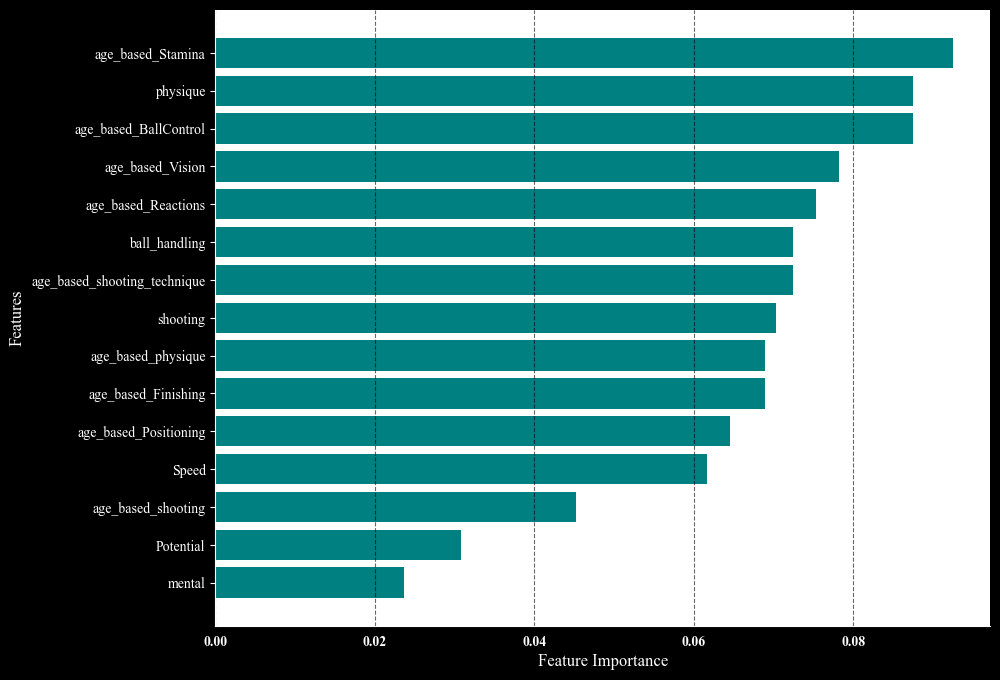

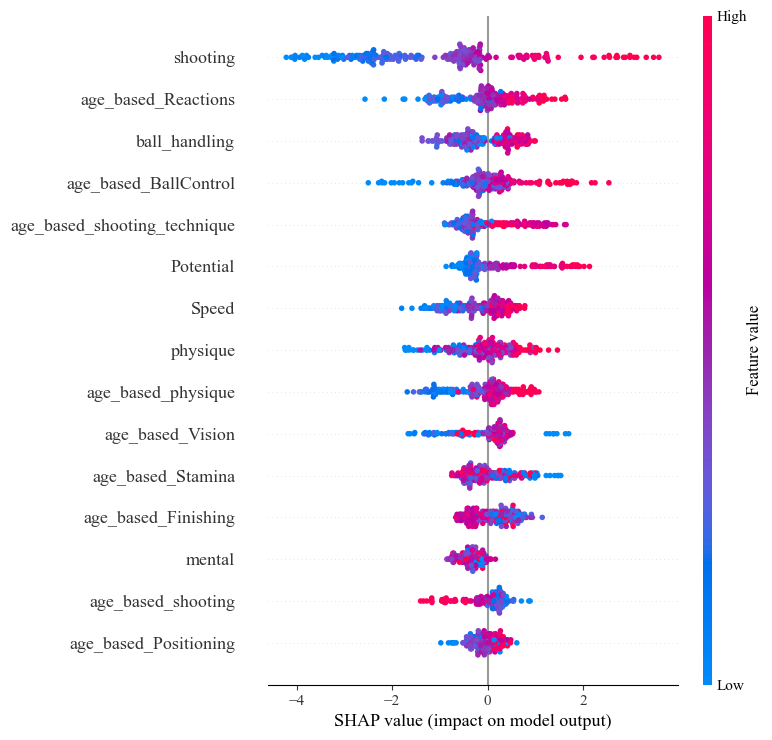

              precision    recall  f1-score   support

       False       0.93      0.92      0.93       211
        True       0.33      0.35      0.34        23

    accuracy                           0.87       234
   macro avg       0.63      0.64      0.63       234
weighted avg       0.87      0.87      0.87       234

Model: Linear Regression
Mean Squared Error: 19.21
Mean Absolute Error: 3.53
R2 Score: 0.37

Model: Decision Tree Regressor
Mean Squared Error: 45.60
Mean Absolute Error: 5.21
R2 Score: -0.50

Model: Random Forest Regressor
Mean Squared Error: 22.30
Mean Absolute Error: 3.87
R2 Score: 0.27

Model: XGBoost Regressor
Mean Squared Error: 24.96
Mean Absolute Error: 4.04
R2 Score: 0.18

Model: LightGBM Regressor
Mean Squared Error: 23.14
Mean Absolute Error: 3.97
R2 Score: 0.24



In [136]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb

from src.sport_analytics.model.eval import plot_feature_importance, log_metrics_in_mlflow_regression, log_feature_list_as_artifact, plot_shap_summary
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



regression_models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'XGBoost Regressor': xgb.XGBRegressor(random_state=42),
    'LightGBM Regressor': lgb.LGBMRegressor(random_state=42),
}


regression_results = {}

# Set the experiment name
mlflow.set_experiment(EXPERIEMENT_NAME)

# Start MLflow run with a specific run name and description
for model_name, model in regression_models.items():
    with mlflow.start_run(run_name=RUN_NAME):

        print(model_name, "training----->")

        # Log parameters
        mlflow.log_param("Model_Name", model_name)
        mlflow.log_params(model.get_params())

        model.fit(X_train_scaled_df, y_train)
       
        y_pred = model.predict(X_test_scaled_df)
        
        # Log Params
        log_feature_list_as_artifact(PLAYER_ATTRIBUTES, filename="feature_list.txt")

        # Create a dictionary with parameters and their values
        params_to_log = {
            'HYPERTRAINING': HYPERTRAINING,
            'CV': CV,
            'SCORING': SCORING,
            'features_anzahl': len(PLAYER_ATTRIBUTES),
            # 'y_train_positives': y_train.sum(),
            # 'y_train_negatives': (~y_train).sum(),
            # 'y_test_positives': y_test.sum(),
            # 'y_test_negatives': (~y_test).sum(),
            'TARGET_OVERALL': TARGET_OVERALL
        }

        # Log parameters using log_params
        mlflow.log_params(params_to_log)

        # Log artifacts
        mlflow.sklearn.log_model(model, model_name)

        # Evaluation Plots (Note: Regression models may not have ROC curves, so adapt this as needed)
        # plot_auc_curves(y_true=y_test, y_proba=model.predict_proba(X_test_scaled_df))
        plot_feature_importance(model, '', top_n=20)
        plot_shap_summary(model=model,df=X_test_scaled_df,K = 30)

            
        # Evaluation Metrics
        log_metrics_in_mlflow_regression(y_test=y_test, y_pred=y_pred)

        # Output for quick evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        from sklearn.metrics import  classification_report
        print(classification_report(y_test>TARGET_OVERALL, y_pred>TARGET_OVERALL))
        regression_results[model_name] = {
            'Model': model,
            'Attributes': PLAYER_ATTRIBUTES,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }

# Evaluate and print results for each model
for model_name, results in regression_results.items():
    print(f"Model: {model_name}")
    print(f"Mean Squared Error: {results['Mean Squared Error']:.2f}")
    print(f"Mean Absolute Error: {results['Mean Absolute Error']:.2f}")
    print(f"R2 Score: {results['R2 Score']:.2f}")
    print()


# evaluate Model

In [137]:
y_test.describe()

count    234.000000
mean      73.269231
std        5.531043
min       58.000000
25%       69.000000
50%       73.000000
75%       77.000000
max       91.000000
Name: target, dtype: float64

In [138]:
my_model = regression_results['Linear Regression']['Model']


In [139]:
result_df = pd.Series(my_model.predict(X_test_scaled_df),index=X_test_scaled_df.index)
len(result_df)

234

In [140]:
bool_ = (result_df>=78)&(y_test>=78)
print(bool_.sum())
result_df[bool_]

22


ID      Name              FIFA
243812  Rodrygo           2021    85.403110
255475  Antony            2021    83.765436
240950  Pedro Gonçalves   2022    84.183741
243014  B. Mbeumo         2021    79.727785
235944  Brais Méndez      2019    78.534821
253002  G. Raspadori      2022    80.134160
251852  K. Adeyemi        2021    79.459539
241721  Rafael Leão       2020    81.913874
239085  E. Håland         2020    82.000166
231447  D. Malen          2020    81.297611
210315  De Tomás          2020    81.357197
226710  G. Scamacca       2022    78.609960
236786  M. Terrier        2019    78.266447
221479  D. Calvert-Lewin  2020    79.544588
237679  R. Kolo Muani     2022    78.561492
216549  A. Sørloth        2021    80.144057
253004  Ansu Fati         2021    83.156005
244193  Jovane Cabral     2021    82.364233
207421  L. Trossard       2020    80.935600
220621  S. Benrahma       2021    78.094115
246147  M. Greenwood      2020    78.064296
243630  J. David          2020    80.341312
d

In [141]:
bool_ = (result_df<78)&(y_test>=78)
print(bool_.sum())
result_df[bool_]

29


ID      Name                FIFA
241852  M. Diaby            2019    73.247500
233500  L. Sinisterra       2020    72.599880
246191  J. Álvarez          2020    76.319945
244622  Puado               2020    77.338566
240243  Matheus Cunha       2019    76.097727
246186  Arthur Cabral       2021    77.704304
245152  S. Giménez          2022    75.577083
230084  L. Nmecha           2019    73.595182
253072  D. Núñez            2021    77.245439
240690  N. González         2019    75.572809
232293  V. Osimhen          2019    74.647118
251892  Beto                2022    76.513771
247463  F. Balogun          2022    72.177580
246430  D. Vlahović         2021    74.740860
224179  Borja Iglesias      2019    75.865645
246242  B. Dia              2021    75.196509
243580  I. Openda           2019    70.475373
228520  E. Ávila            2020    75.898302
234570  Jota                2019    76.993938
242444  João Félix          2019    75.963394
221697  O. Watkins          2019    77.740437
2

In [142]:
bool_ = (result_df[0]>=78)&(y_test<=78)
print(bool_.sum())
result_df[bool_]

KeyError: 0

In [ ]:
bool_ = (result_df<=78)&(y_test>78)
print(bool_.sum())
result_df[bool_]

21


ID      Name                FIFA
241852  M. Diaby            2019    72.923913
235944  Brais Méndez        2019    77.864400
233500  L. Sinisterra       2020    73.016838
251852  K. Adeyemi          2021    77.653613
246191  J. Álvarez          2020    74.700494
240243  Matheus Cunha       2019    75.269007
236786  M. Terrier          2019    77.471245
253072  D. Núñez            2021    77.512470
240690  N. González         2019    75.028399
232293  V. Osimhen          2019    75.491016
251892  Beto                2022    77.013690
247463  F. Balogun          2022    71.060518
246430  D. Vlahović         2021    75.241292
224179  Borja Iglesias      2019    76.928342
246242  B. Dia              2021    76.167239
243580  I. Openda           2019    70.282594
228520  E. Ávila            2020    75.758329
242444  João Félix          2019    76.229824
251566  Gabriel Martinelli  2020    76.420597
256516  Nico Williams       2021    74.928860
237712  V. Castellanos      2020    68.394400
d

In [ ]:
bool_ = (result_df<78)&(y_test<78)
print(bool_.sum())
result_df[bool_].sort_values().tail(20)

171


ID      Name              FIFA
220287  J. Dinenno        2021    76.397508
213418  C. Akpom          2020    76.532340
251105  D. Joveljić       2020    76.554460
237960  Mama Baldé        2020    76.554500
245396  V. Supryaga       2021    76.691816
252042  João Pedro        2021    76.730349
240332  Brenner           2022    76.741786
233848  J. Hauge          2021    76.757159
229556  Allano            2019    76.769304
241522  J. Wind           2021    76.770930
226380  Hwang Hee Chan    2019    76.876708
246762  S. Koita          2021    77.084208
228747  O. Idrissi        2019    77.095317
252037  Fábio Silva       2020    77.124882
247888  S. Esposito       2021    77.365459
240740  C. Hudson-Odoi    2019    77.404333
221014  Carlos Fernández  2020    77.488024
245940  S. Wamangituka    2020    77.530366
212228  I. Toney          2022    77.904588
238050  C. Ejuke          2021    77.924170
dtype: float64

In [ ]:
from sklearn.metrics import  classification_report
print(classification_report(y_test>78, result_df>78))

              precision    recall  f1-score   support

       False       0.90      0.92      0.91       196
        True       0.53      0.45      0.49        38

    accuracy                           0.85       234
   macro avg       0.71      0.69      0.70       234
weighted avg       0.84      0.85      0.84       234

